This homework is largely based on the sample solution provided by group 2, which can be found in [this notebook](https://colab.research.google.com/drive/1ImJHDNy_s5c-C5bPIJh4Y5pjfuB0iSYZ?usp=sharing#scrollTo=TChH5gQO6CRa)

Imports

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds

!pip install tensorflow_text
import tensorflow_text as tf_text

import tqdm.notebook as note
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy

from collections import Counter
from google.colab import drive
from tensorflow.keras.layers import BatchNormalization, Reshape, Conv2DTranspose, Flatten, Conv2D, Dense, Dropout

In [20]:
# bash code to mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing the data

Converting and preparing the corpus

In [21]:
def clean_text(corpus):
    """ removes new line and special characters from a given text using regex
        Args:
            corpus (str): raw text
    """
    # replace all whitespace characters with a space (to remove tab and newline, etc) but still be able to split by space
    corpus = re.sub('\s', ' ', corpus)
    # remove all special characters (everything that is not a letter from a-z or whitespace)
    corpus = re.sub(r'[^a-zA-z\s]', '', corpus)
    
    return corpus

In [22]:
# convert to lower case and remove new line and special characters
corpus = clean_text(open('/content/drive/MyDrive/bible.txt').read().lower())

# split the corpus by whitespace into a list of words
corpus = corpus.split()

# we start with only the 10.000 most common words in our corpus
most_common_words = 10000

Getting the 10000 most common words of the corpus

In [23]:
# collects all unique tokens in our corpus (unique_tokens), their indexes and their counts. For easier handling, this is mapped from a tensor to a numpy array
unique_tokens, indices, counts = map(lambda x:x.numpy(), tf.unique_with_counts(corpus))

# sort the unique tokens by their counts in a decreasing manner and take the 10.000th element to know where to cut off.
cut_off_value = sorted(counts, reverse=True)[most_common_words]

# The most common words (all unique tokens to be kept) are mapped in a dictionary to a singular ID number as the vocabulary
# The sample solution opted to use the decode() function, which can be found here for any pleb like me that didn't know it before https://www.tutorialspoint.com/python/string_decode.htm
vocab = {token.decode():i for i, token in enumerate(unique_tokens[counts > cut_off_value])}

# Creating a reversed dictionary to get the corresponding words back when later looking at the results
inverse_vocab = {vocab[a]:a for a in vocab}

## Now all words that are not frequent enough are removed by a boolean mask
# For all tokens we check whether their count is frequent enough by comparing it to the cut off value
mask = np.array([counts[indices[index]] > cut_off_value for index in range(len(corpus))])
# the boolean mask is then applied to the corpus
corpus = np.array(corpus)[mask]

Subsampling (to be removed)

In [24]:
# Subsampling constant given in homework
SUB_SAMPLING_CONSTANT=0.001

# Updating the counts after removing words from the corpus
_, new_indices, new_counts = map(lambda x:x.numpy(), tf.unique_with_counts(corpus))

# Normalize counts to get frequencies
new_counts = new_counts.astype(float)/len(corpus) 

# Collection of frequencies for every token in the corpus in an np.array
frequencies= np.array([new_counts[new_indices[i]] for i in range(len(corpus))])

# Calculate the sub-sampling probabilities by a given formula
# formula specified in the homework: (1+sqrt(freq/sub_sampling_constant)) * (sub_sampling_constant/freq)
sub_sampling_probs = np.array([(1 + np.sqrt(frequencies[i]/SUB_SAMPLING_CONSTANT))  * (SUB_SAMPLING_CONSTANT/frequencies[i]) for i in range(len(corpus))])

# Create a new boolean mask that samples from a uniform distribution (0, 1) by using np.random.random()
# Note: If the subsample is smaller then the sub-sampling probability the word is not removed
sub_sampling_mask = np.array([np.random.random() < sub_sampling_probs[i] for i in range(len(corpus))])
# the boolean mask is then applied to the corpus
corpus = corpus[sub_sampling_mask]

## Negative Sampling preparation
# A tf.int64 tensor of all the state to be sampled
complete_data_to_be_sampled = tf.cast(tf.reshape(tf.convert_to_tensor(list(vocab.values())),[1,-1]),tf.int64)

# Word frequencies again after subsampling
_, new_indices, new_counts = map(lambda x:x.numpy(), tf.unique_with_counts(corpus))
new_counts = new_counts.astype(float)/len(corpus)  

Creating the target context pairs


In [25]:
# Create Dataset with target context pairs [target_word, context_word] with subsampling
# Vectorizing the words by their IDs
corpus = np.vectorize(lambda x: vocab[x])(corpus)

# Constants
CONTEXT_WINDOW_SIZE = 4
BATCH_SIZE = 128

# aggregator for our data
data = [] 

# iterate over all tokens in the text
for token in range(0, len(corpus)):
    # then over all tokens in the context window
    for token_win in range(-CONTEXT_WINDOW_SIZE // 2, (CONTEXT_WINDOW_SIZE // 2) + 1): 
        # add up both indices to get position
        pos = token + token_win
        # if the position is in the array range
        if (pos > 0) and (pos != token) and (pos < len(corpus) - 1):
            # append the input on the left, the target on the right
            data.append((corpus[token], corpus[pos])) 

# Convert the data to an array and cut some last values of, so we can batch the data nicely
data = np.array(data)[:(len(data)//(BATCH_SIZE)) * BATCH_SIZE]

# Create the dataset with inputs (corresponding to the 1st column) and targets (corresponding to the 2nd column)
data = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

# apply shuffling and batching
data = data.shuffle(1000).batch(BATCH_SIZE)

# Reshaping the labels to the form (BATCH_SIZE, 1)
data = data.map(lambda a,b: (a, tf.reshape(b,(-1,1))))

# Prefetch, Cache
data = data.prefetch(20).cache()

# Skipgram Model

In [26]:
class SkipGram(tf.keras.layers.Layer):

    def __init__(self, embedding_size, vocab_size):
        super(SkipGram, self).__init__()

        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.build(0)   # call the build function

    def build(self, input_shape):
        # we wnat the nce_weights to be randomly distributed at the start
        self.nce_weights = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_size])) 
        self.nce_biases = tf.Variable(tf.zeros([self.vocab_size])) # and the biases to be 0

        self.embedding = tf.Variable(tf.random.uniform([self.vocab_size, self.embedding_size])) # we choose a uniform random variable for the embedding matrix

    def call(self, words, labels):
        # word frequencies for negative sampling
        global new_counts

        # all the data we can sample from
        global complete_data_to_be_sampled 
        
        # we chose 64 negative sampled words
        number_of_negative_samples = 64 

        # getting the embeddings
        words_embedded = tf.nn.embedding_lookup(self.embedding, words)

        # getting the sampled values for the negative sampling according to the word frequencies
        sampled_values = tf.random.fixed_unigram_candidate_sampler(complete_data_to_be_sampled, self.vocab_size,
                                                                    number_of_negative_samples, False,
                                                                    range_max=self.vocab_size, unigrams=new_counts)
        
        # calculate the loss, we give our sampled values to our nce_loss_function
        loss = tf.nn.nce_loss(weights=self.nce_weights, biases=self.nce_biases, labels=labels, inputs=words_embedded,
                                num_sampled=number_of_negative_samples, num_classes=self.vocab_size, sampled_values=sampled_values)

        # take mean over all batches
        return tf.reduce_mean(loss)

# Training
Function for keeping track of nearest words and printing them

In [27]:
def print_closest_word(Model,words_of_interest):
    """
    Prints what specified model characterised as closest words to list of
    given words.
    ##Params 
        - tf.keras.layers.Layer Model = specified tensorflow model
        - stringlist words_of_interest = words we want to know similarity of
    """
    # convert our embedding matrix to a numpy array, so we can quickly do some operations
    ar = Model.embedding.numpy()
    # for all words of interest
    for word in words_of_interest:

        i = vocab[word] # get the id of the word

        # get the index of the closest word via np.argmin (returns the index of the minimal value) and the scipy.spatial.distance.cosine function, which calculate the spatial cosine distance for us
        # if we have the same word, we want the distance to be infitive

        closest = np.argmin([scipy.spatial.distance.cosine(ar[i],ar[q]) if q!=i else np.inf for q in range(len(ar)) ])

        # then print the word again, via the use of our inverse vocab
        print(f"Closest to {word} is {inverse_vocab[closest]}")

Running the code to train the network

In [28]:
tf.keras.backend.clear_session()

# interesting words for comparison purposes
words_of_interesting = ["holy", "father", "wine", "poison", "love", "strong", "day"]

# define hyperparameters
learning_rate = tf.constant(0.001, dtype=tf.float64)
NUM_EPOCHS = 10
HIDDEN_SIZE = 64
VOCAB_SIZE = len(vocab)

# Initializes the model
Model = SkipGram(HIDDEN_SIZE, VOCAB_SIZE)
# optimizer 
optimizer = tf.optimizers.Adam(learning_rate)    
# initialize np.array for losses
train_losses = np.empty(0)

# training of our model for num_epochs
for epoch in range(NUM_EPOCHS):
    # print current epoch
    print(f'Epoch {str(epoch)}')
    # loss aggregator reset for each epoch
    epoch_loss_agg = np.empty(0)

    # Loop over all our training data with nice progress bar
    for input, target in note.tqdm(data, position=0, leave=True):
        with tf.GradientTape() as tape:
            loss = Model(input, target)
        # Apply the gradients
        gradients = tape.gradient(loss, Model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
        # aggregate the loss
        epoch_loss_agg = np.append(epoch_loss_agg, loss)

    # gather the train losses               
    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))            
    
    print(f"Finished epoch {epoch+1}")
    print(train_losses[-1])
    # after an epoch print all the closest words
    print_closest_word(Model, words_of_interesting)

Epoch 0


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 1
565.3248901665977
Closest to holy is amnon
Closest to father is goat
Closest to wine is anamim
Closest to poison is freed
Closest to love is provided
Closest to strong is me
Closest to day is affliction
Epoch 1


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 2
341.64462421824805
Closest to holy is heir
Closest to father is wrest
Closest to wine is dagon
Closest to poison is freed
Closest to love is life
Closest to strong is ephrath
Closest to day is come
Epoch 2


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 3
299.59679010410144
Closest to holy is grounded
Closest to father is no
Closest to wine is jehudi
Closest to poison is admonish
Closest to love is pity
Closest to strong is oreb
Closest to day is come
Epoch 3


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 4
265.8440084600956
Closest to holy is touched
Closest to father is god
Closest to wine is self
Closest to poison is applied
Closest to love is pity
Closest to strong is oreb
Closest to day is time
Epoch 4


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 5
243.33832831470872
Closest to holy is touched
Closest to father is god
Closest to wine is myself
Closest to poison is diggeth
Closest to love is life
Closest to strong is regardeth
Closest to day is time
Epoch 5


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 6
224.516809399308
Closest to holy is i
Closest to father is god
Closest to wine is myself
Closest to poison is diggeth
Closest to love is life
Closest to strong is regardeth
Closest to day is time
Epoch 6


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 7
211.8700741301142
Closest to holy is i
Closest to father is god
Closest to wine is oil
Closest to poison is asps
Closest to love is life
Closest to strong is presence
Closest to day is time
Epoch 7


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 8
203.75368349941107
Closest to holy is i
Closest to father is son
Closest to wine is gold
Closest to poison is asps
Closest to love is life
Closest to strong is presence
Closest to day is when
Epoch 8


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 9
198.09846583744434
Closest to holy is i
Closest to father is son
Closest to wine is gold
Closest to poison is asps
Closest to love is life
Closest to strong is apparel
Closest to day is when
Epoch 9


  0%|          | 0/16342 [00:00<?, ?it/s]

Finished epoch 10
193.95591357824867
Closest to holy is i
Closest to father is son
Closest to wine is gold
Closest to poison is asps
Closest to love is life
Closest to strong is apparel
Closest to day is when


# Visualization

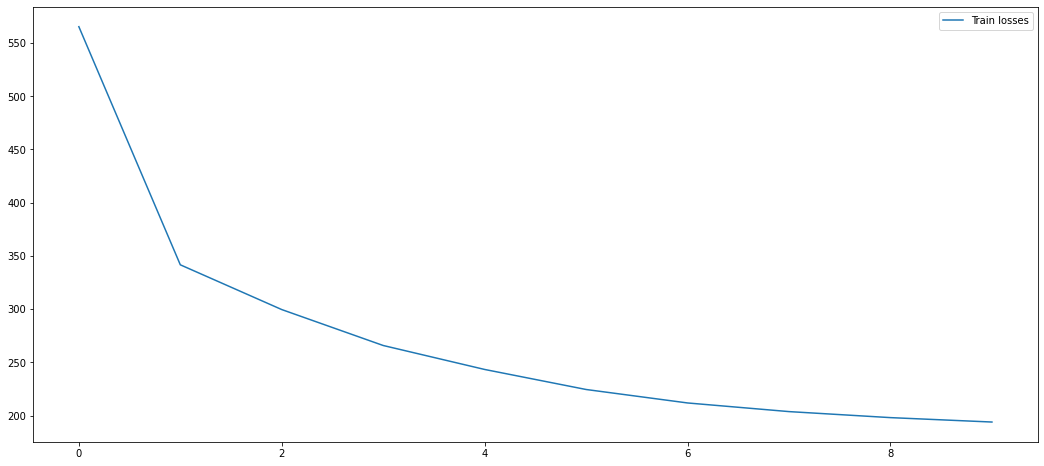

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.plot(range(NUM_EPOCHS), train_losses, label="Train losses")
plt.legend()
plt.show()